<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Desde-txt-a-dataframe" data-toc-modified-id="Desde-txt-a-dataframe-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Desde txt a dataframe</a></span></li><li><span><a href="#Idiomas-por-canción" data-toc-modified-id="Idiomas-por-canción-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Idiomas por canción</a></span></li><li><span><a href="#Transformar-lista-de-idiomas-detectados" data-toc-modified-id="Transformar-lista-de-idiomas-detectados-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transformar lista de idiomas detectados</a></span></li><li><span><a href="#Idiomas-como-lista-de-strings" data-toc-modified-id="Idiomas-como-lista-de-strings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Idiomas como lista de strings</a></span></li><li><span><a href="#Exploración-idiomas" data-toc-modified-id="Exploración-idiomas-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exploración idiomas</a></span></li><li><span><a href="#Filtrar-para-un-solo-idioma" data-toc-modified-id="Filtrar-para-un-solo-idioma-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Filtrar para un solo idioma</a></span><ul class="toc-item"><li><span><a href="#Idioma-=-Inglés-(puro)" data-toc-modified-id="Idioma-=-Inglés-(puro)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Idioma = Inglés (puro)</a></span></li><li><span><a href="#Idioma-=-Español-(puro)" data-toc-modified-id="Idioma-=-Español-(puro)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Idioma = Español (puro)</a></span></li></ul></li><li><span><a href="#Dataset-final-(hasta-ahora,-solo-existen-'en'-y-'es')" data-toc-modified-id="Dataset-final-(hasta-ahora,-solo-existen-'en'-y-'es')-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Dataset final (hasta ahora, solo existen 'en' y 'es')</a></span></li></ul></div>

<p><font size="6">Creación de los datasets</font></p>

In [86]:
import re
import os
from os import walk
import bs4 
from bs4 import BeautifulSoupBV 
import time
import csv
from langdetect import detect
from langdetect import detect_langs
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

In [81]:
pd.set_option('display.width', 900)
pd.set_option('display.max_colwidth', 1)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_columns', None)

In [ ]:
start = time.time()

# Desde txt a dataframe

La siguiente función analiza el directorio raíz y extrae la información desde los archivos, hacia un Dataframe.<br>
Input: directorio con archivos txt dentro de carpetas. <br>
Output: archivo df_darklyrics.csv (tarda 670 segundos)<br>
<br>
Una carpeta por banda. Un archivo TXT por disco. <br>
Los archivos vienen en TXT pero su estructura es HTML.<br> 
La información se extrae con Beautiful Soup.<br>
Con regex se elimina la mayor cantidad posible de texto no lírico, como saludos, agradecimientosentre otros elementos. <br>
Para obtener los archivos se utilizó el scrapping de este repo: https://github.com/Ptolemaios-cl/Dark-Lyrics-

In [ ]:
print (start)
print ('\nProcesando.....')
path = './lyrics'
regex_end = 'Thanks to .*? for sending these lyrics.|Thanks to .*? for sending track .*? lyrics.|Thanks to .*? for sending tracks .*? lyrics.|Thanks to .*? for correcting track .*? lyrics.|Thanks to .*? for correcting tracks .*? lyrics.|Bass|Guitars|Vocals|Keyboards|Drums|\[.*?\]| LYRICS|Submits, comments, corrections are welcomed at webmaster@darklyrics.com'
cancion_con_todo = []
def parsefiles(path):E 
	
	for root, dirs, files in os.walk(path):
		files = [f for f in files if not f[0] == '.']
		dirs[:] = [d for d in dirs if not d[0] == '.']
		for file in files:
			if file.endswith(".txt"):
				with open(root + '/' + file) as album:
					file_contents = album.read()
					soup = BeautifulSoup(file_contents, 'html.parser')
					band_dirt = str(soup.a.string)
					band_name = band_dirt.replace(' LYRICS', '')
					album_dirt = str(soup.h2.string)
					album_name_year = album_dirt.replace('album:', '')
					album_name = str(re.findall(r'"([^"]*)"', album_name_year))
					album_name = album_name[2:-2]
					album_year = str(re.findall(r'\(([^"]*)\)', album_name_year))
					album_year = album_year[2:-2]
					lyrics_div = soup.find('div', class_='lyrics')
					lyrics = lyrics_div.prettify().split('<h3>')
					del lyrics[0]
					for lyric in lyrics:
						song_title = lyric.split('\n')[2]
						song_title = song_title.strip()
						cleanr = re.compile('<.*?>')
						lyric = re.sub(cleanr, '', lyric)
						lyric = lyric.replace('\n','')
						lyric = re.sub(regex_end, '', lyric)
						lyric = ' '.join(lyric.split())
						lyric = lyric.replace(str(band_name),' ')
						lyric = lyric.replace(str(song_title),' ')
						lyric = lyric.strip()
						cancion_con_todo.append((band_name,album_name,album_year,song_title,lyric))
parsefiles(path)
pd.set_option('display.max_columns', None)
df = pd.DataFrame(cancion_con_todo)
df.columns = ['band_name','album_name','album_year','song_title','lyric']
print (df)
print (df.shape)
df.to_csv("./df_darklyrics.csv")

end = time.time()

print('\ntime to process: ',end - start, 'seconds')
print ("fin")

# Idiomas por canción
<br>
La siguiente función lee la letra de cada canción y se añade una columna 'lang' al dataframe. <br>Aproximadamente 44 minutos.  <br>

In [ ]:
start = time.time()

In [ ]:
lang_lyric = []
print ('Obteniendo idiomas para cada letra............\n\n\n')
def lang_detection(x):
	for lyric in x.lyric:
		try:
			idioma = detect_langs(lyric)
			lang_lyric.append(idioma)
		except Exception as e:
			idioma = 'ninguno'
			lang_lyric.append(idioma)
lang_detection(df)
df['lang'] = lang_lyric
#df.to_pickle("./archivos_modelos/df_darklyrics_idiomas_prob.pkl")
df.to_csv("./from_scratch/df_darklyrics_idiomas_prob.csv")

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print('\n\n\n\n\n\n\nTime elapsed detecting languages for each song: \n')
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
print ("fin")

# Transformar lista de idiomas detectados

In [ ]:
df = pd.read_csv('./from_scratch/df_darklyrics_idiomas_prob.csv')

In [ ]:
idiomas = []

def prepara_multi_lang (df_multi_lang):
    for list_probs in df_multi_lang['lang']:
        idiomas.append(re.sub(r"[(:)(\d)(.)(\d+)]", "", str(list_probs)))

prepara_multi_lang (df)

In [ ]:
df['idiomas'] = idiomas

In [ ]:
df.to_csv("./from_scratch/df_darklyrics_idiomas_prob_listaidiomas.csv")

# Idiomas como lista de strings

In [34]:
df_idiomas_como_lista = pd.read_csv("./from_scratch/df_darklyrics_idiomas_prob_listaidiomas.csv")

In [36]:
df_solo_la_lista = df_idiomas_como_lista.idiomas
df_solo_la_lista.colummns = ['idiomas']

In [37]:
df_solo_la_lista = pd.DataFrame(df_solo_la_lista)
df_solo_la_lista['idiomas'] = df_solo_la_lista.idiomas.apply(lambda x: x[1:-1].split(','))

In [39]:
df_idiomas_como_lista['len_lan'] = df_idiomas_como_lista['idiomas'].astype(str).map(len)

In [ ]:
sin_ninguno = df_idiomas_como_lista[df_idiomas_como_lista.idiomas != 'ninguno']

In [42]:
sin_ninguno.loc[sin_ninguno['len_lan'] <= 4, 'un_idioma'] = 'True'
sin_ninguno.loc[sin_ninguno['len_lan'] > 4, 'un_idioma'] = 'False'

In [ ]:
columnas = [0,1]
result = sin_ninguno.drop(sin_ninguno.columns[columnas], axis = 1)
result = result.reset_index(drop=True)

In [53]:
result.to_csv("./from_scratch/df_idiomas.csv")

# Exploración idiomas

In [170]:
df_idiomas = pd.read_csv('./from_scratch/df_idiomas.csv')

In [ ]:
df_nose = df_idiomas.idiomas
delta = df_nose.value_counts()
delta = pd.DataFrame(delta)

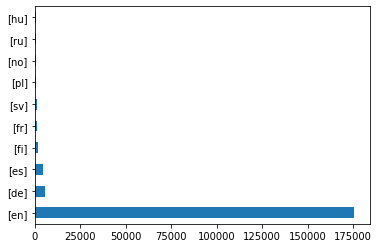

In [185]:
%matplotlib inline
frecuencia_lang = df_idiomas.idiomas.value_counts()[:10].plot(kind='barh')

# Filtrar para un solo idioma

In [59]:
df_idiomas = pd.read_csv('./from_scratch/df_idiomas.csv')

In [ ]:
df3 = df_idiomas[df_idiomas.un_idioma == True]

## Idioma = Inglés (puro)

In [66]:
df4 = df3[df3.idiomas == '[en]']
df4.to_csv("./from_scratch/001_df_ingles_puro.csv")

## Idioma = Español (puro)

In [67]:
df5 = df3[df3.idiomas == '[es]']
df5.to_csv("./from_scratch/002_df_espanol_puro.csv")

# Dataset final (hasta ahora, solo existen 'en' y 'es')

In [ ]:
df1 = pd.read_csv('./from_scratch/002_df_ingles_puro.csv')